In [1]:
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("./data/preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("./data/preprocessed_pes_with_energy.parquet")

In [2]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)



feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit', "outage"])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

INFO:root:No features found to onehotencode.


### __Wind Energy Forecast__

__baseline__

In [3]:
import model_utils
import numpy as np
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

Saved Quantile Regressor model for quantile 0.1 to qr_model_wind\qr_model_quantile_0.1.pkl
Saved Quantile Regressor model for quantile 0.2 to qr_model_wind\qr_model_quantile_0.2.pkl
Saved Quantile Regressor model for quantile 0.3 to qr_model_wind\qr_model_quantile_0.3.pkl
Saved Quantile Regressor model for quantile 0.4 to qr_model_wind\qr_model_quantile_0.4.pkl
Saved Quantile Regressor model for quantile 0.5 to qr_model_wind\qr_model_quantile_0.5.pkl
Saved Quantile Regressor model for quantile 0.6 to qr_model_wind\qr_model_quantile_0.6.pkl
Saved Quantile Regressor model for quantile 0.7 to qr_model_wind\qr_model_quantile_0.7.pkl
Saved Quantile Regressor model for quantile 0.8 to qr_model_wind\qr_model_quantile_0.8.pkl
Saved Quantile Regressor model for quantile 0.9 to qr_model_wind\qr_model_quantile_0.9.pkl
Quantile Regressor Pinball Score: 29.548653036104035


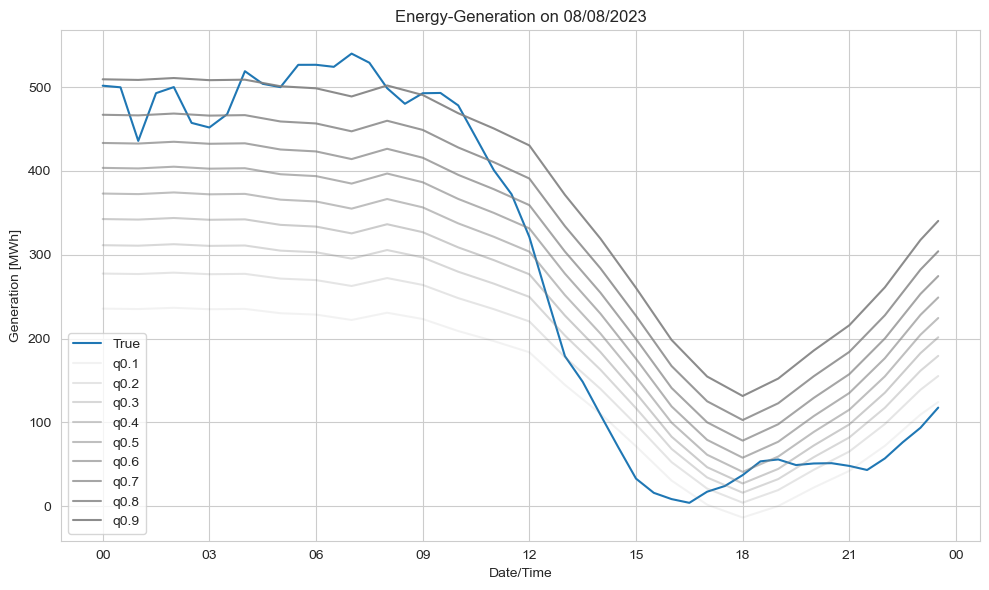

In [4]:
qr_model_wind.plot_quantils(feature_engineerer_wind_baseline.y_test.index, qr_model_wind.q_predictions, quantiles=quantiles, year=2023, month=8, day=8)

__xgboost__

In [5]:
importlib.reload(model_utils)
import numpy as np

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

model_save_dir_xgboost = "xgboost_model_wind"
hyperparams = {
            # Use the quantile objective function.
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": quantiles,
            "learning_rate": 0.01,
            "max_depth": 8
        }




xgboost_model_wind = model_utils.XGBoostModel(feature_engineerer_wind, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False, hyperparams=hyperparams, num_boost_round=45, early_stopping_rounds=10)
xgboost_model_wind.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_wind.pinball_score()}")

[0]	Train-quantile:97.92826	Val-quantile:88.89174
[1]	Train-quantile:96.87875	Val-quantile:87.93583
[2]	Train-quantile:95.83857	Val-quantile:86.98683
[3]	Train-quantile:94.81454	Val-quantile:86.05301
[4]	Train-quantile:93.80460	Val-quantile:85.13856
[5]	Train-quantile:92.80414	Val-quantile:84.23691
[6]	Train-quantile:91.81520	Val-quantile:83.34545
[7]	Train-quantile:90.84079	Val-quantile:82.46295
[8]	Train-quantile:89.87940	Val-quantile:81.59510
[9]	Train-quantile:88.92838	Val-quantile:80.73971
[10]	Train-quantile:87.98875	Val-quantile:79.89025
[11]	Train-quantile:87.06208	Val-quantile:79.05516
[12]	Train-quantile:86.14467	Val-quantile:78.22422
[13]	Train-quantile:85.23935	Val-quantile:77.40688
[14]	Train-quantile:84.34536	Val-quantile:76.59953
[15]	Train-quantile:83.46144	Val-quantile:75.80376
[16]	Train-quantile:82.58839	Val-quantile:75.01538
[17]	Train-quantile:81.72602	Val-quantile:74.23502
[18]	Train-quantile:80.87233	Val-quantile:73.46448
[19]	Train-quantile:80.02938	Val-quantile

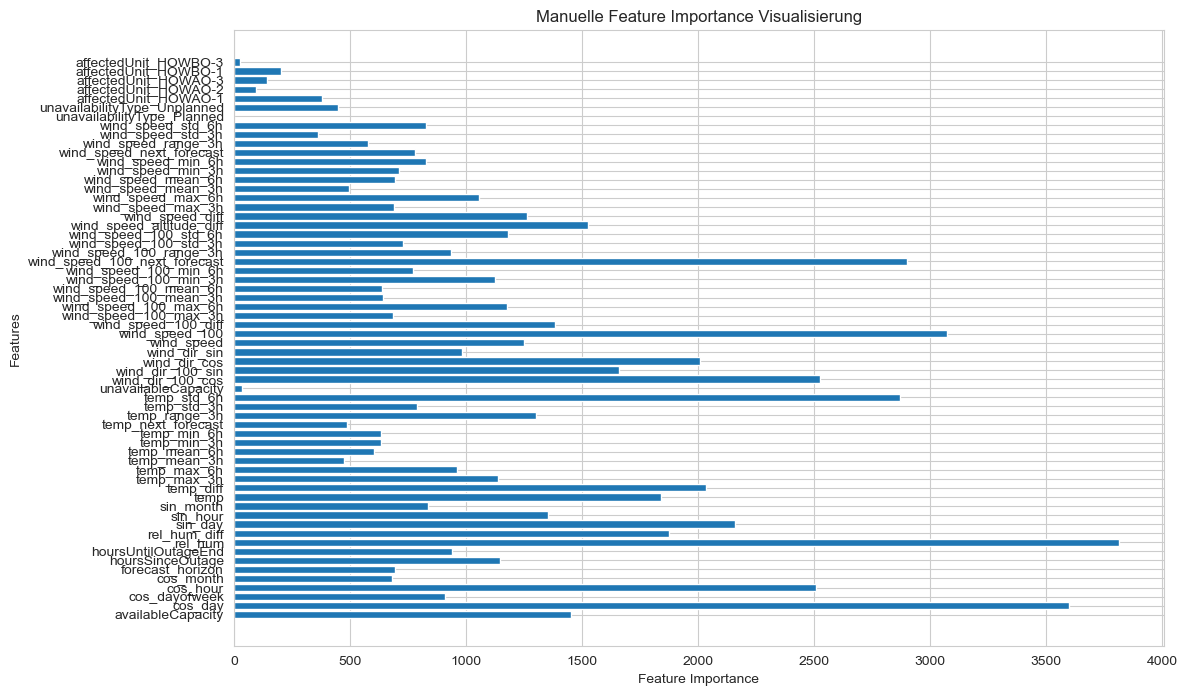

In [6]:
xgboost_model_wind.plot_feature_importance()

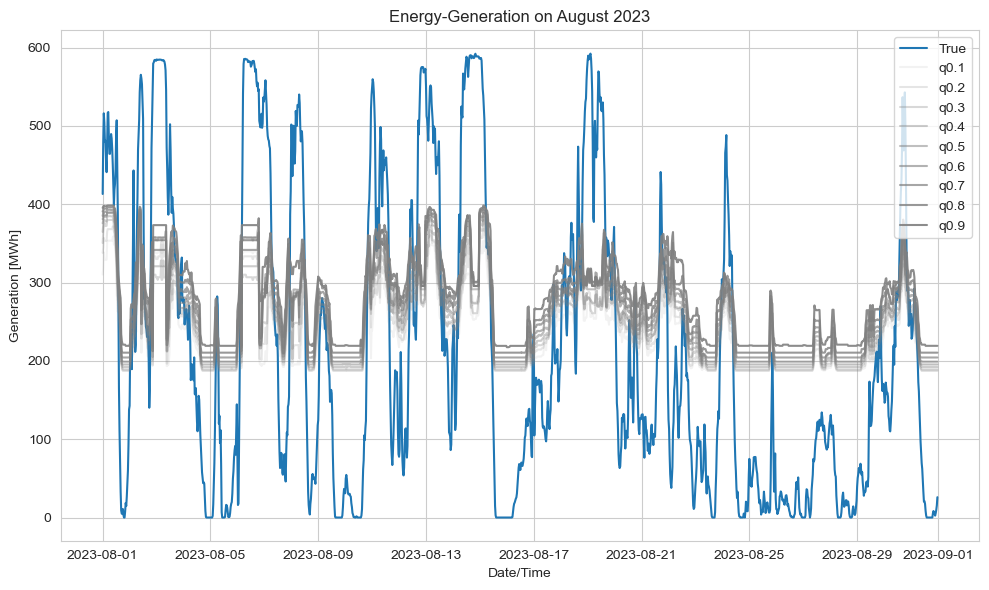

In [7]:
xgboost_model_wind.plot_quantils(daterange=feature_engineerer_wind.y_test.index, y=xgboost_model_wind.q_predictions, quantiles=quantiles, year=2023, month=8)

### __Solar Energy Forecast__

__baseline modell__

In [8]:
quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

Saved Quantile Regressor model for quantile 0.1 to qr_model_solar\qr_model_quantile_0.1.pkl
Saved Quantile Regressor model for quantile 0.2 to qr_model_solar\qr_model_quantile_0.2.pkl
Saved Quantile Regressor model for quantile 0.3 to qr_model_solar\qr_model_quantile_0.3.pkl
Saved Quantile Regressor model for quantile 0.4 to qr_model_solar\qr_model_quantile_0.4.pkl
Saved Quantile Regressor model for quantile 0.5 to qr_model_solar\qr_model_quantile_0.5.pkl
Saved Quantile Regressor model for quantile 0.6 to qr_model_solar\qr_model_quantile_0.6.pkl
Saved Quantile Regressor model for quantile 0.7 to qr_model_solar\qr_model_quantile_0.7.pkl
Saved Quantile Regressor model for quantile 0.8 to qr_model_solar\qr_model_quantile_0.8.pkl
Saved Quantile Regressor model for quantile 0.9 to qr_model_solar\qr_model_quantile_0.9.pkl
Quantile Regressor Pinball Score: 15.253271903353985


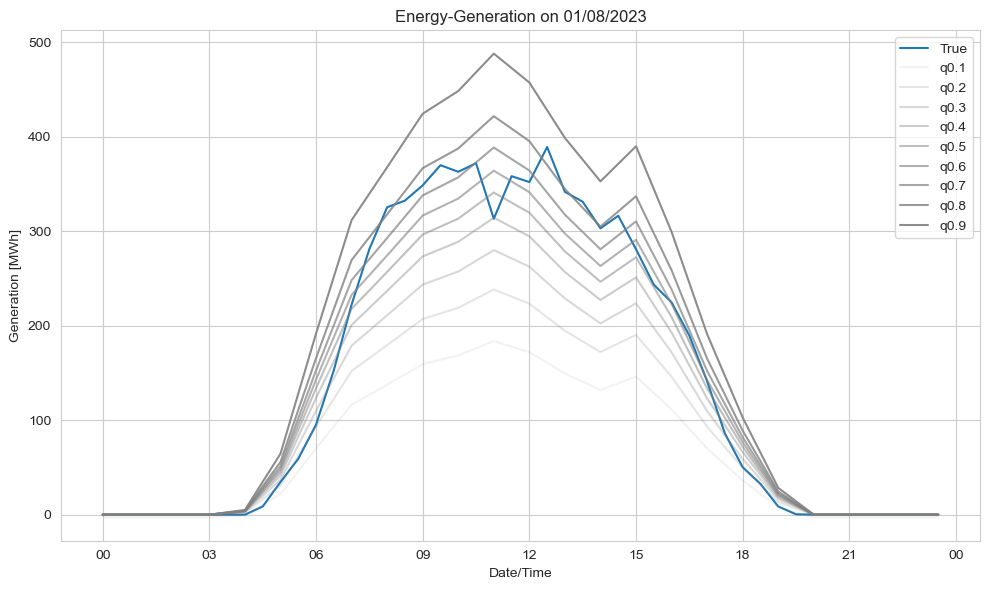

In [9]:
qr_model_solar.plot_quantils(daterange=feature_engineerer_solar_baseline.y_test.index, y=qr_model_solar.q_predictions, quantiles=quantiles, year=2023, month=8, day=1)

__xgboost__

In [10]:
quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

model_save_dir_xgboost = "xgboost_model_solar"

xgboost_model_solar = model_utils.XGBoostModel(feature_engineerer_solar, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False)
xgboost_model_solar.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_solar.pinball_score()}")

[0]	Train-quantile:44.08710	Val-quantile:89.95033
[1]	Train-quantile:42.03996	Val-quantile:86.05491
[2]	Train-quantile:40.15760	Val-quantile:82.27750
[3]	Train-quantile:38.39213	Val-quantile:78.74011
[4]	Train-quantile:36.76346	Val-quantile:75.33538
[5]	Train-quantile:35.21170	Val-quantile:72.08230
[6]	Train-quantile:33.74776	Val-quantile:68.96714
[7]	Train-quantile:32.34922	Val-quantile:66.00327
[8]	Train-quantile:31.01233	Val-quantile:63.15234
[9]	Train-quantile:29.73973	Val-quantile:60.44455
[10]	Train-quantile:28.53631	Val-quantile:57.85607
[11]	Train-quantile:27.39519	Val-quantile:55.40058
[12]	Train-quantile:26.32350	Val-quantile:53.00841
[13]	Train-quantile:25.29117	Val-quantile:50.79924
[14]	Train-quantile:24.31632	Val-quantile:48.64392
[15]	Train-quantile:23.39352	Val-quantile:46.61919
[16]	Train-quantile:22.51412	Val-quantile:44.65922
[17]	Train-quantile:21.67975	Val-quantile:42.82100
[18]	Train-quantile:20.88930	Val-quantile:41.07388
[19]	Train-quantile:20.14059	Val-quantile

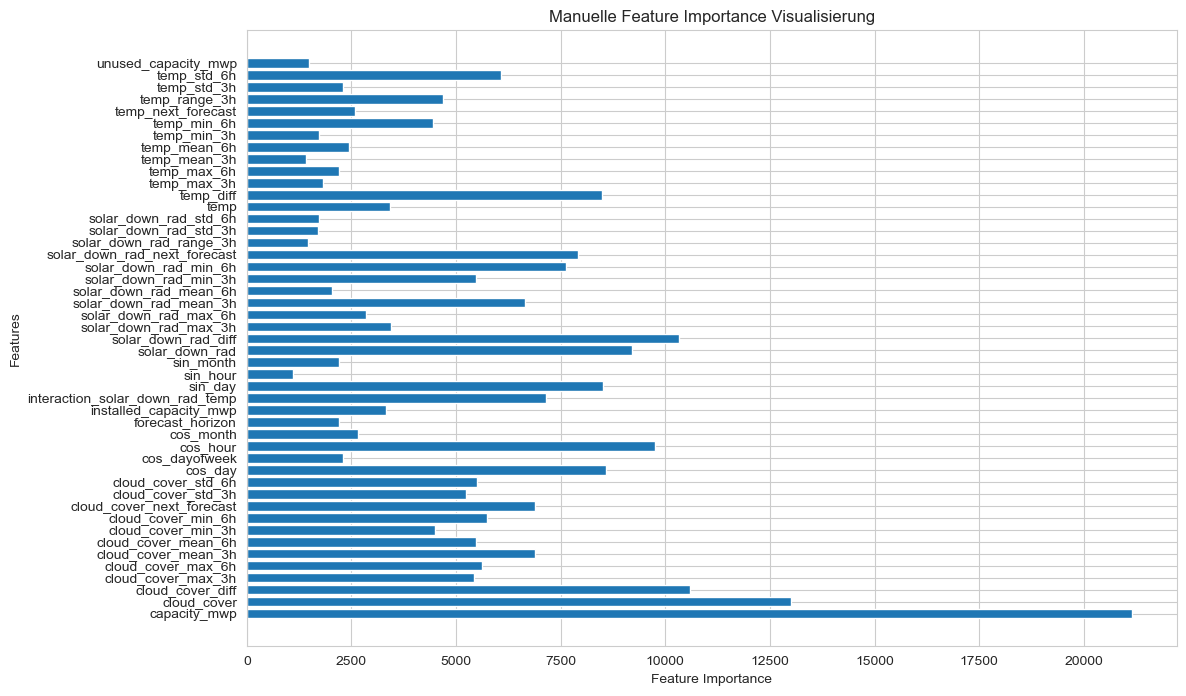

In [11]:
xgboost_model_solar.plot_feature_importance()

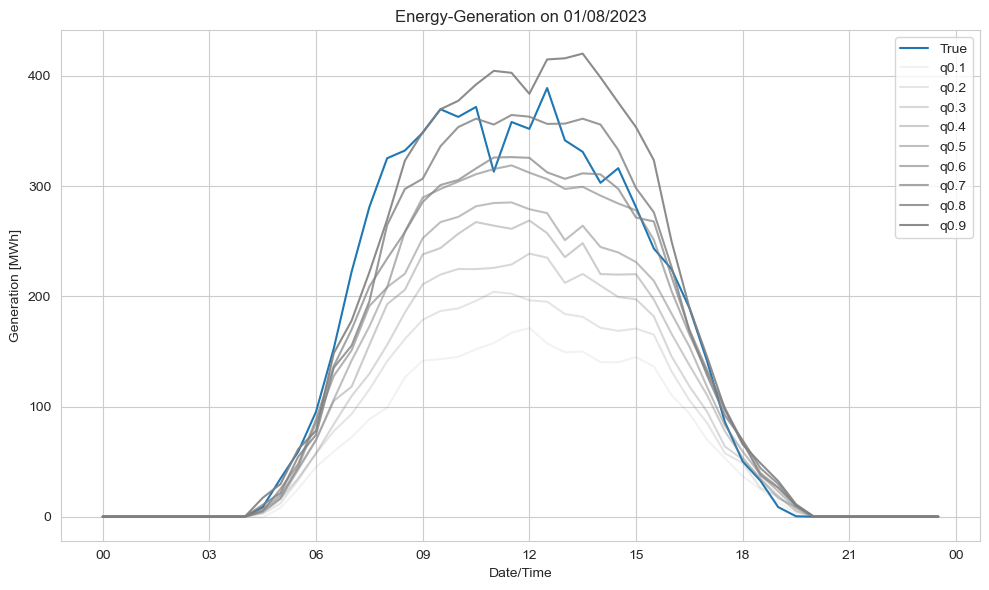

In [12]:
xgboost_model_solar.plot_quantils(daterange=feature_engineerer_solar.y_test.index, y=xgboost_model_solar.q_predictions, quantiles=quantiles, year=2023, month=8, day=1)

### __Lightgbm implementation__

In [21]:
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind"

lgbm_model_wind = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_wind\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_wind\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_wind\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_wind\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_wind\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_wind\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_wind\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_wind\lgbm_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from lgbm_model_wind\lgbm_model_quantile_0.9.pkl
Using the loaded pr

In [22]:
lgbm_model_wind.predict(feature_engineerer_wind.X_test)

{'0.1': array([351.81940979, 369.89608532, 351.4461631 , ..., 521.60582747,
        525.76198012, 531.52477237]),
 '0.2': array([437.51190192, 444.56482392, 446.77225892, ..., 530.18055143,
        544.55706137, 539.76167082]),
 '0.3': array([460.11864881, 472.78871213, 470.66575377, ..., 555.73957364,
        557.77948086, 557.1578041 ]),
 '0.4': array([478.25294305, 492.25353823, 488.62993928, ..., 554.8706124 ,
        554.89231571, 555.54037229]),
 '0.5': array([496.92749343, 511.60048842, 507.83718389, ..., 562.38377187,
        564.13799742, 563.21394693]),
 '0.6': array([523.9395136 , 523.3126304 , 541.23644944, ..., 565.32930441,
        564.92433483, 563.49972716]),
 '0.7': array([530.55952654, 538.07124279, 535.39536247, ..., 564.87448899,
        567.5444593 , 566.33387701]),
 '0.8': array([558.40213909, 558.22034811, 555.56713137, ..., 570.03764954,
        570.75061169, 571.22366915]),
 '0.9': array([573.63745536, 573.63745536, 560.25701065, ..., 569.20438084,
        569.

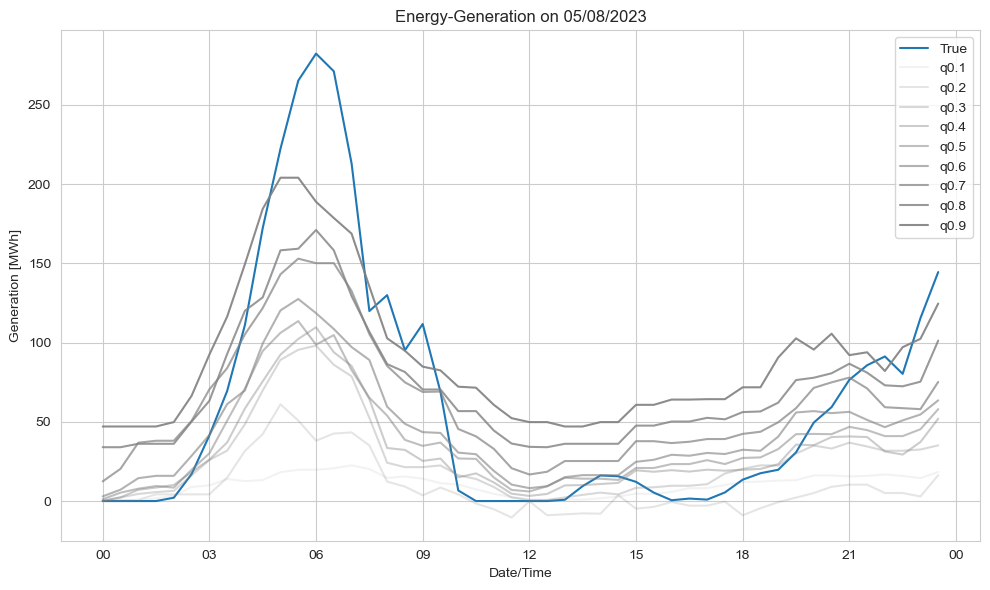

In [14]:
lgbm_model_wind.plot_quantils(feature_engineerer_wind.y_test.index, lgbm_model_wind.q_predictions, quantiles, month=8, day=5)

In [15]:
quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar"

lgbm_model_solar = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_solar.pinball_score()}")

[LightGBM] [Info] Total Bins 10364
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 47
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 4.82569	valid's quantile: 6.40726
[100]	train's quantile: 3.79819	valid's quantile: 5.73256
Early stopping, best iteration is:
[94]	train's quantile: 3.8437	valid's quantile: 5.71441
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_solar\lgbm_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 10364
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 47
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 6.96261	valid's quantile: 9.40234
[100]	train's quantile: 5.68551	valid's quantile: 9.03766
Early stopping, best iteration is:
[81]	train's quantile: 5.91077	valid's quantile: 8.99938
Saved Quantile Regressor model for quantile 0.2 to lgbm_model_solar\lgbm_model_quantile_0.2.pkl
[LightGBM] [Info]

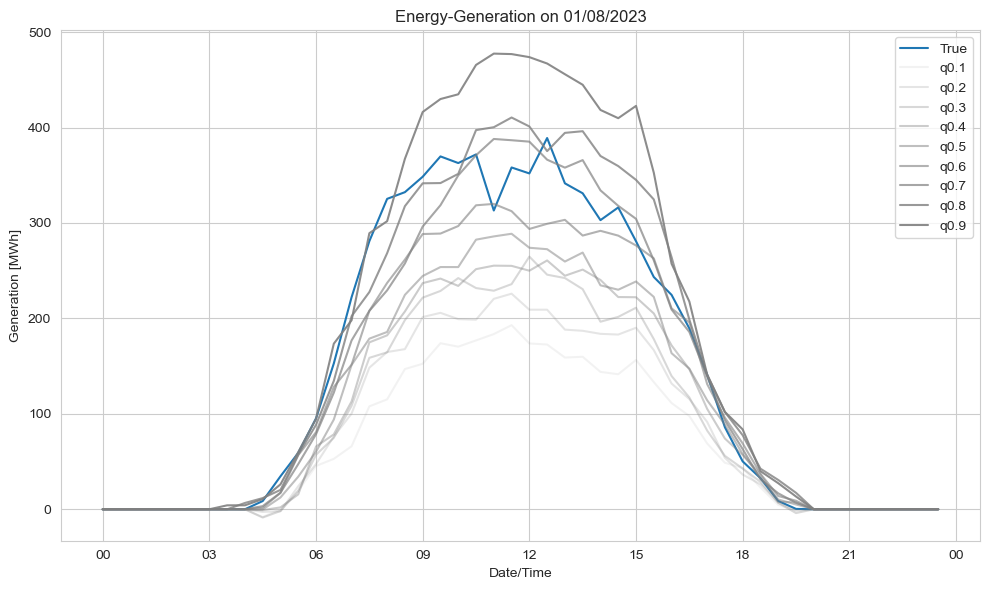

In [16]:
lgbm_model_solar.plot_quantils(feature_engineerer_solar.y_test.index, lgbm_model_solar.q_predictions, quantiles, year=2023, month=8, day=1)

In [17]:
import neural_networks
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

nn_wind = neural_networks.Trainer(feature_engineerer_wind, neural_networks.q_model,quantiles, in_shape=67)
nn_wind.train_and_test()

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 287.8994445800781
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 244.62522888183594
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 228.39422607421875
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 208.0419464111328
40. epoche startet: 
41. epoche startet: 
42. epoche sta

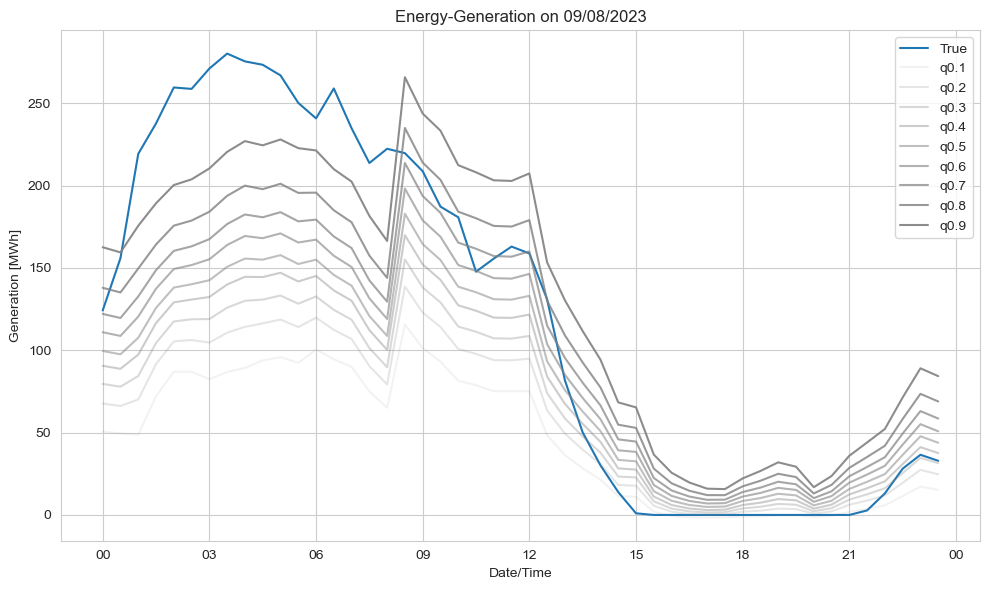

In [18]:
nn_wind.plot_quantils(feature_engineerer_wind.y_test.index, nn_wind.q_prediction_nn, quantiles, day=9)

In [19]:
import neural_networks
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

nn_solar = neural_networks.Trainer(feature_engineerer_solar, neural_networks.q_model, quantiles, in_shape=48)
nn_solar.train_and_test()

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 88.83892059326172
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 84.2905044555664
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 82.5297622680664
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 81.23576354980469
40. epoche startet: 
41. epoche startet: 
42. epoche startet

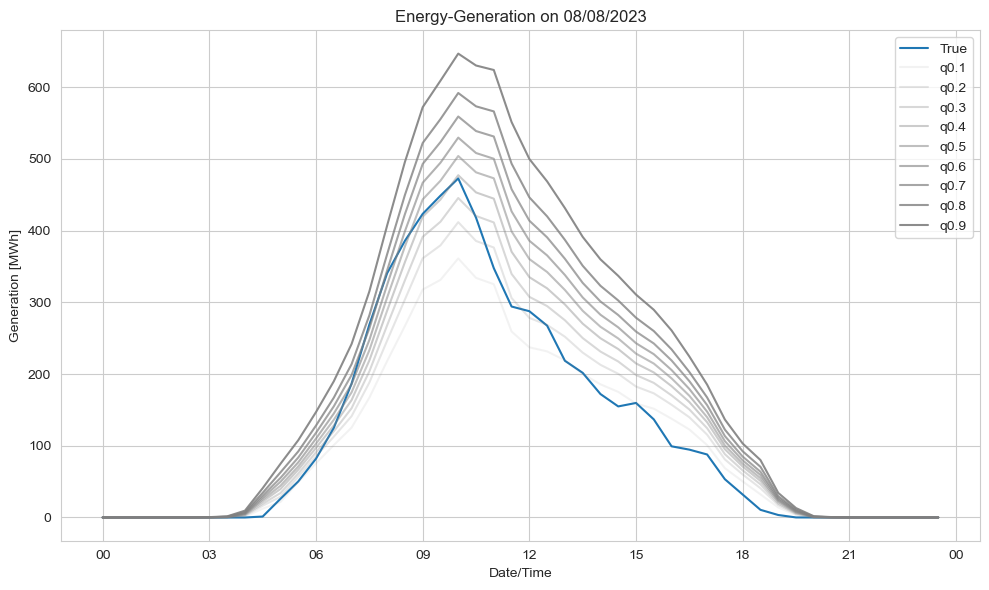

In [20]:
nn_solar.plot_quantils(feature_engineerer_solar.y_test.index, nn_solar.q_prediction_nn, quantiles, day=8)